<a href="https://colab.research.google.com/github/utsavdatta-git/Identifying-Misleading-Superlatives-in-News/blob/main/Identifying_misleading_news_headlines_due_to_misuse_of_superlatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is wrong with the below news item?


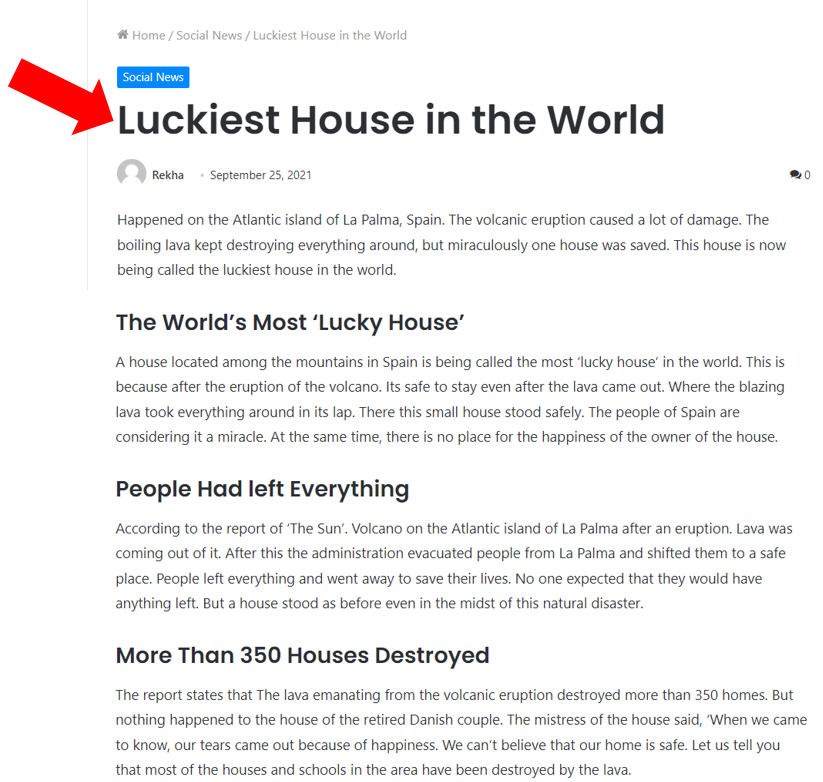


At first glance, it seems to be a completly harmless piece of news with an attractive headline except for the fact that it unncessarily uses a superlative without justifying its claim in the body that follows. Consider the words "this is luckiest house in the world", there is no justification, quatification or explanation for that claim anywhere in the 4 paragraphs that constitute the body of the news item. Clearly, the headline is an exaggerated one meant to serve as a clickbait!

On some further research across a few other news websites, I found few more such examples. For example, consider these:

*Prince Philip: the world’s luckiest man, yet he seethed with anger!*

*The 27 Best Ways to Train a Dog!*

This is just the tip of the iceberg when it comes to exaggerated and misleading headlines online. However, the specific problem of unnecessary/misleading use of superlatives in news headlines is even more rampant in the Hindi language (one the most widely spoken languages in india). Consider these examples⁉

*ये हैं दुनिया के सबसे खतरनाक द्वीप, जहां जाकर आप देंगे 'मौत को दावत'!*

*सर्दियों में होने वाली शादियों में इन पांच तरीकों को अपनाकर दिखेंगी सबसे 'स्टाइलिश'!*

*फेफड़े का कैंसर फैलने की सबसे बड़ी वजह बना वायु प्रदूषण!*

In all the above news headlines, the superlatives are neither justified through proper quantification nor they are supported or even mentioned again (proving they were just used to mislead), in their corresponding bodies.

Some justified use of superlatives in news headlines are given below:

***पीएम मोदी ने विश्‍व की सबसे लंबी सुरंग की राष्ट्र को समर्पित***

*प्रधानमंत्री नरेंद्र मोदी ने हिमाचल प्रदेश के रोहतांग में विश्‍व की सबसे लंबी अटल सुरंग का उद्घाटन किया। 9.02 किलोमीटर की इस टनल के शुरु होने से मनाली और लेह के बीच सड़क की दूरी 46 किलोमीटर कम हो जाएगी। समुद्र तल से 10 हजार फुट की ऊंचाई पर अत्याधुनिक तकनीक और इलेक्टो-मैक्निकल प्रणाली से इसका निर्माण किया गया है।*


***चंद्रग्रहण लगा, 580 साल में सबसे लंबी अवधि का ग्रहण***

*स्पेस डॉट कॉम के मुताबिक इस चंद्र ग्रहण की अवधि सबसे ज़्यादा ध्यान खींचने वाली है. चंद्र ग्रहण तीन घंटे, 28 मिनट और 24 सैकेंड तक रहेगा और यह 580 सालों में सबसे लंबा आंशिक ग्रहण बन जाएगा.*

As a result of this observation, I wanted to explore the possibility of Deep Learning models (especially Recurrent Neural Networks for Natural Language Processing use cases) to identify such misleading headlines and highlight them to the readers to enable them make an informed choice. The rest of the notebook describes the exploration of various techniques to solve this problem with a demo of the model being used on some real-life news articles at the end.

# Data collection technique

I present this use case as a binary classification problem. As I am dealing with a vernacular language here, there is no labelled dataset that is already available. I, therefore, scraped some popular and not-so popular online news websites for data. This was followed by going through each headline-body pair of news items and labelling them as "misleading (1)" or "accurate (0)". I created a python app that recursively scrapes websites and presents the user with a headline-body pair on the screen and asks whether the pair is accurate or misleadingly uses superlatives. This sped up the process a little bit!

An indicative snippet of the code is given below (it may not work as expected in colab, run it as a desktop app). it saves the output as an excel file as per user inputs as shown below:

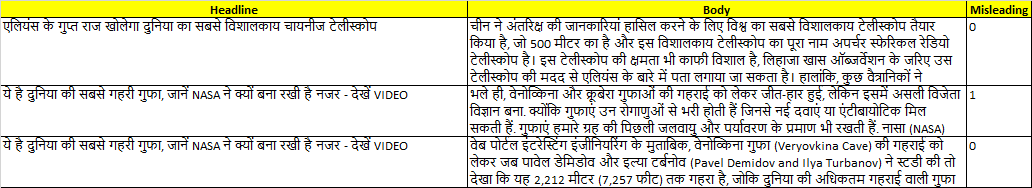

Web scraping code: https://github.com/utsavdatta-git/Identifying-Misleading-Superlatives-in-News/tree/main/NewsScraper

# Package installations

In [1]:
! pip install fasttext
! pip install pdpipe
! pip install transformers
! pip install sentencepiece

     |████████████████████████████████| 68 kB 4.7 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3123786 sha256=075b6eacc58504286e7fa8b67dac25d56f27369c7568b35491896bd3e0a27c09
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 60 kB 5.4 MB/s 
  Created wheel for decore: filename=decore-0.0.1-py2.py3-none-any.whl size=4191 sha256=3462cc92c6cf718ee05064ba843e968c1e300c942724123e1a202966d25a64e1
  Stored in directory: /root/.cache/pip/wheels/71/8f/e1/b37357faaa92c7fbd2a8f735f96fcf032df04bcd3875465a3f
Successfully built decore
     |████████████████████████████████| 3.4 MB 12.9 MB/s 
     |████████████████████████████████| 3.3 MB 51.5 MB/s 
     |████████████████████████████████| 895 kB 64.5 MB/s 
     |████████████████████████████████| 61 kB 518 kB/s 
     |████

# Some basic package imports

In [2]:
import pandas as pd
import fasttext
import fasttext.util
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
import string
import pdpipe as pdp
from keras.utils.vis_utils import plot_model
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pickle
from transformers import TFAutoModel, AutoTokenizer, BertModel, BertTokenizer
from joblib import dump, load
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Reading the news headline and body data, shuffling them and splitting them up into train and test sets

In [3]:
# Read train data
news_dataset_full = pd.read_excel("/content/drive/MyDrive/Datasets/news_dataset.xlsx", sheet_name="Train")
print(f"Dataset shape: {news_dataset_full.shape}")
# Shuffle the dataframe
news_dataset_full = news_dataset_full.sample(frac=1).reset_index(drop=True)
news_dataset_full.head()

Dataset shape: (751, 3)


,Headline,Body,Misleading
0,गुना और बीनागंज में डेंगू के डंक से सबसे अधिक ...,जिले में डेंगू के डंक से अभी तक 150 बच्चे बीमा...,0
1,T20 World Cup में भारत के लिए सबसे बड़ा विलेन स...,नई दिल्ली – T20 World Cup में रविवार को न्यूजी...,1
2,Kerala Rain: केरल में अक्टूबर महीने में हुई सब...,केरल में अक्टूबर सबसे अधिक बारिश वाला महीना सा...,0
3,Mercedes की ये हैचबैक कार है देश में ‘सबसे Fas...,Mercedes-AMG A 45 S 4MATIC+ के एक्सटीरियर कंपन...,1
4,IPL Retention: महेंद्र सिंह धोनी को यूं ही नही...,धोनी ने जडेजा के लिए दिया बलिदान\nइससे यह साफ ...,0


In [4]:
# Performing train test split
from sklearn.model_selection import train_test_split
y = news_dataset_full.pop("Misleading")
news_dataset_train, news_dataset_test, y_train, y_test = train_test_split(news_dataset_full, y, test_size=0.2, random_state=42)

In [5]:
print(news_dataset_test.head())
print(news_dataset_test.shape)

                                              Headline                                               Body
473                  देश का चौथा सबसे गरीब राज्य है MP  भोपाल. देश के गरीब राज्यों में मध्य प्रदेश चौथ...
357  जम्मू कश्मीर का लेह सबसे ठंडा स्थान रहा, तापमा...  श्रीनगर (भाषा)। जम्मू कश्मीर में लेह सबसे ठंडा...
133  उत्तर प्रदेश में UAPA के तहत सबसे ज्यादा गिरफ्...  गृह राज्य मंत्री नित्यानंद राय ने सोमवार को लो...
250  Covid-19 : देश में पिछले 24 घंटे में 6,990 नए ...  गौरतलब है कि विश्‍व स्‍वास्‍थ्‍य संगठन यानी WH...
299  800 साल पहले मौजूद था सबसे बड़ा Eagle, शरीर मे...  वैज्ञानिकों ने हाल ही डिजिटल मॉडल्स और सिमुलेश...
(151, 2)


In [6]:
print(news_dataset_train.head())
print(news_dataset_train.shape)

                                              Headline                                               Body
131  कोरोना एंटीबॉडीज, केरल में सबसे कम, ICMR रिपोर...  ICMR Sero Survey Report: इंडियन काउंसिल ऑफ मेड...
44   भारत आई दुनिया की सबसे सस्ती इलेक्ट्रिक कार, द...  कार कंपनी के ME प्योर-इलेक्ट्रिक प्लेटफॉर्म पर...
70   सुनामी: 11 साल पहले आई थी इस युग की सबसे बड़ी ...  26 दिसंबर 2004 को 9.1 तीव्रता का एक भयानक भूकं...
673         सबसे अधिक विज्ञान और अतिरिक्त विषय में फेल  धनबाद | मैट्रिक परीक्षा 2018 में सबसे अधिक विज...
208  UP Election: अखिलेश यादव के सबसे बड़े चुनावी द...  बता दें कि पश्चिमी यूपी की सियासत में जाट, मुस...
(600, 2)


# Data Preprocessing:
1. Remove leading and trailing spaces
2. Replace numbers with a special word (संख्या) that will represent all  numbers, as numbers hold special importance in this task (may not be useful)
3. Replace % sign with प्रतिशत (a word representation of the symbol) (may not be useful)
4. Remove all English words
5. Remove punctuations
6. Remove some special characters
7. Remove extra spaces within sentences
8. Remove some basic stop words

In [7]:
def remove_leading_trailing_spaces(x):
  return x.strip()

def remove_line_feeds(x):
  x = x.replace("\r", "")
  return x.replace("\n", "")  

def replace_numbers(x):
  return re.sub(r'[0-9]+', ' संख्या ', x)

def replace_percent(x):
  return x.replace('%', ' प्रतिशत ')

def remove_english_words(x):
  return re.sub(r'[a-zA-Z]+', '', x)

def remove_punctuations(x):
  return re.sub('[%s]' % re.escape(string.punctuation), '' , x)

def remove_string_numbers(x):
  return re.sub('W*dw*', '', x)

def remove_numbers(x):
  return re.sub('[0-9]', '', x)

def remove_unwanted_chars(x):
  x = x.replace("–", "").replace(":", "").replace('।', '').replace("’", "").replace("‘", "")
  return x

def remove_extra_spaces(x):
  return re.sub(' +', ' ', x)   

def remove_stopwords(x):
  stopwords_list = ["अत", "अपना", "अपनी", "अपने", "अभी", "अंदर", "आदि", "आप", "इत्यादि", "इन ", "इनका", "इन्हीं", "इन्हें", "इन्हों", "इस", 
  "इसका", "इसकी", "इसके", "इसमें", "इसी", "इसे", "उन", "उनका", "उनकी", "उनके", "उनको", "उन्हीं", "उन्हें", "उन्हों", "उस", "उसके", "उसी", 
  "उसे", "एवं", "एस", "ऐसे", "और", "कर", "करता", "करते", "करना", "करने", "करें", "कहते", "कहा", "का", "कि", "किन्हें", "किन्हों", "किया", "किर", 
  "किस", "किसी", "किसे", "की", "के", "को", "कोई", "कौन", "कौनसा", "गया", "घर", "जब", "जहाँ", "जा", "जिन", "जिन्हें", "जिन्हों", "जिस", "जिसे", 
  "जीधर", "जैसा", "जैसे", "जो", "तक", "तब", "तरह", "तिन्हें", "तिन्हों", "तिसे", "तो", "था", "थी", "थे", "दिया", "द्वारा", "न", "नके", "ना", "ने", 
  "पर", "पूरा", "पे", "फिर", "बनी", "बही", "बाद", "बाला", "भी", "मे", "में", "यदि", "यह", "यहाँ", "यही", "या", "यिह", "ये", "रखें", "रहा", "रहे", "लिए", 
  "लिये", "व", "वर्ग", "वह", "वहाँ", "वहीं", "वाले", "वुह", "वे", "साभ", "से", "सो", "संग", "ही", "हुआ", "हुई", "हुए", "है", "हैं", "हो", "होता", "होती", 
  "होते", "होना", "होने", "लें"]   
  return ' '.join("" if i in stopwords_list else i for i in x.split()) 

def text_preprocessing(data):
  pipeline = pdp.ApplyByCols("Headline", remove_english_words)
  pipeline += pdp.ApplyByCols("Headline", remove_line_feeds)
  #pipeline += pdp.ApplyByCols("Headline", replace_numbers)
  #pipeline += pdp.ApplyByCols("Headline", replace_percent)
  pipeline += pdp.ApplyByCols("Headline", remove_punctuations)
  pipeline += pdp.ApplyByCols('Headline', remove_string_numbers)
  pipeline += pdp.ApplyByCols('Headline', remove_numbers)
  pipeline += pdp.ApplyByCols('Headline', remove_unwanted_chars)
  pipeline += pdp.ApplyByCols('Headline', remove_stopwords)
  pipeline += pdp.ApplyByCols('Headline', remove_extra_spaces)
  pipeline += pdp.ApplyByCols("Headline", remove_leading_trailing_spaces)

  pipeline += pdp.ApplyByCols("Body", remove_english_words)
  pipeline += pdp.ApplyByCols("Body", remove_line_feeds)
  #pipeline += pdp.ApplyByCols("Body", replace_numbers)
  #pipeline += pdp.ApplyByCols("Body", replace_percent)
  pipeline += pdp.ApplyByCols("Body", remove_punctuations)
  pipeline += pdp.ApplyByCols('Body', remove_string_numbers)
  pipeline += pdp.ApplyByCols('Body', remove_numbers)
  pipeline += pdp.ApplyByCols('Body', remove_unwanted_chars)
  pipeline += pdp.ApplyByCols('Body', remove_extra_spaces)
  pipeline += pdp.ApplyByCols('Body', remove_stopwords)
  pipeline += pdp.ApplyByCols('Body', remove_extra_spaces)
  pipeline += pdp.ApplyByCols("Body", remove_leading_trailing_spaces)

  data = pipeline(data)
  
  return data

In [8]:
# Performing data pre processing using the above mentioned steps on both train and test data. These steps will also be used to clean any new data for future predictions
news_dataset_train_cleaned = text_preprocessing(news_dataset_train)
news_dataset_test_cleaned = text_preprocessing(news_dataset_test)

In [9]:
news_dataset_train_cleaned.head()

,Headline,Body
131,कोरोना एंटीबॉडीज केरल सबसे कम रिपोर्ट खुलासा,इंडियन काउंसिल ऑफ मेडिकल रिसर्च पिछले महीने कर...
44,भारत आई दुनिया सबसे सस्ती इलेक्ट्रिक कार देखें...,कार कंपनी प्योरइलेक्ट्रिक प्लेटफॉर्म काम करती ...
70,सुनामी साल पहले आई युग सबसे बड़ी तबाही,दिसंबर तीव्रता एक भयानक भूकंप आया साथ लाया मौत...
673,सबसे अधिक विज्ञान अतिरिक्त विषय फेल,धनबाद मैट्रिक परीक्षा सबसे अधिक विज्ञान अतिरिक...
208,अखिलेश यादव सबसे बड़े चुनावी दांव फेल जुटीं मा...,बता दें पश्चिमी यूपी सियासत जाट मुस्लिम दलित व...


In [10]:
news_dataset_test_cleaned.head()

,Headline,Body
473,देश चौथा सबसे गरीब राज्य,भोपाल देश गरीब राज्यों मध्य प्रदेश चौथे स्थान ...
357,जम्मू कश्मीर लेह सबसे ठंडा स्थान तापमान शून्य ...,श्रीनगर भाषा जम्मू कश्मीर लेह सबसे ठंडा स्थान ...
133,उत्तर प्रदेश तहत सबसे ज्यादा गिरफ्तारियां इनमे...,गृह राज्य मंत्री नित्यानंद राय सोमवार लोकसभा ए...
250,देश पिछले घंटे नए केस आए सामने दिनों सबसे कम म...,गौरतलब विश्‍व स्‍वास्‍थ्‍य संगठन यानी कोविड नए...
299,साल पहले मौजूद सबसे बड़ा शरीर सिर डालकर नोच ले...,वैज्ञानिकों हाल डिजिटल मॉडल्स सिमुलेशन बनाकर प...


# Baseline Model
## As a starting point, I have first created a quick and basic baseline model to solve the task. In this baseline model, I have used TF-TDF features (for each observation the features for headline and body have been concatenated) and put them through a "Gradient boosting classifier)

In [11]:
# Baseline model creation using Gradient Boosting classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

corpus = news_dataset_train_cleaned["Headline"] + news_dataset_train_cleaned["Body"]
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
X_train_headline = vectorizer.transform(news_dataset_train_cleaned["Headline"])
X_train_body = vectorizer.transform(news_dataset_train_cleaned["Body"])
X_train_headline_body = np.concatenate((X_train_headline.toarray(), X_train_body.toarray()), axis=1)

parameters = {'learning_rate':(1.0, 0.5, 0.8, 2.0), 'max_depth':[1, 4, 6],
              'loss':['deviance', 'exponential'], 'n_estimators': [50, 100, 150, 200], 
              'max_depth': [2, 4, 6, 10]}
gb_clf = GradientBoostingClassifier()              
clf = GridSearchCV(gb_clf, parameters, scoring='accuracy')
clf.fit(X_train_headline_body, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': (1.0, 0.5, 0.8, 2.0),
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [2, 4, 6, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [12]:
# Getting the best scores
print(f"Best Accuracy score: {clf.best_score_}")
# Getting the best model
gb_clf_best = clf.best_estimator_

Best Accuracy score: 0.8


              precision    recall  f1-score   support

           0       0.79      0.91      0.84        75
           1       0.89      0.76      0.82        76

    accuracy                           0.83       151
   macro avg       0.84      0.83      0.83       151
weighted avg       0.84      0.83      0.83       151

Accuracy: 0.83, F1 Score: 0.82


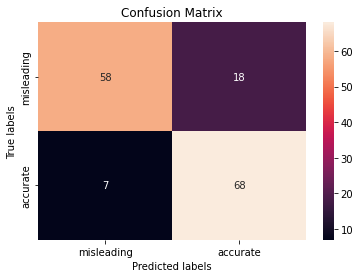

In [13]:
X_test_headline = vectorizer.transform(news_dataset_test_cleaned["Headline"])
X_test_body = vectorizer.transform(news_dataset_test_cleaned["Body"])

# Testing the model on held-out test data
X_test_headline_body = np.concatenate((X_test_headline.toarray(), X_test_body.toarray()), axis=1)
pred_baseline = gb_clf_best.predict(X_test_headline_body)
true_baseline = y_test
from sklearn.metrics import classification_report
print(classification_report(true_baseline, pred_baseline))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true_baseline, pred_baseline, labels=[1,0]), annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true_baseline, pred_baseline), 2)}, F1 Score: {round(f1_score(true_baseline, pred_baseline), 2)}")

# Saving the Baseline model

In [15]:
# Save the tf idf vectorizer
dump(vectorizer, '/content/drive/MyDrive/Datasets/Saved Models/gb_best_model/tf_tdf_vectorizer.joblib')
# Save the model
dump(gb_clf, '/content/drive/MyDrive/Datasets/Saved Models/gb_best_model/gb_clf.joblib')

['/content/drive/MyDrive/Datasets/Saved Models/gb_best_model/gb_clf.joblib']

# Recurrent neural network models (with Attention mechamism)

Before model building and training, some further pre-processing steps like Tokenization, Padding and Word vectors loading need to be done. This is almost a routine steps to be performed for any keras NLP task.

In [16]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="UNKNOWN")
tokenizer.fit_on_texts(
    news_dataset_train_cleaned["Headline"]+news_dataset_train_cleaned["Body"]
)

# Text to sequences
train_headline_sequences = tokenizer.texts_to_sequences(news_dataset_train_cleaned["Headline"])
train_body_sequences = tokenizer.texts_to_sequences(news_dataset_train_cleaned["Body"])

# Pad sequences
train_headline_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    train_headline_sequences, padding='post'
)

train_body_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    train_body_sequences, padding='post'
)
# Seperately getting target label
train_news_dataset_cleaned_label = y_train

In [17]:
# Load the fasttext model for Hindi language
# It can be downloaded from here https://fasttext.cc/docs/en/crawl-vectors.html
ft_hindi = fasttext.load_model('/content/drive/MyDrive/WordVecs/cc.hi.300.bin')
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 300
def create_embedding_matrix(vocab_size, embedding_dim, word_index, fasttext_model):
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = fasttext_model.get_word_vector(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix    
embedding_matrix = create_embedding_matrix(vocab_size, embedding_dim, tokenizer.word_index, ft_hindi)  

# Modelling (Bi-LSTM + Dot Product Attention + FFNN)



In [25]:
# Creating an custom Attention layer
class CustomAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(CustomAttention, self).__init__()

  def call(self, inputs):
    headline_body_dot = tf.matmul(inputs[1], inputs[0], transpose_b=True) # (batch_size, T_headline, dim) . (batch_size, T_body, dim) = (batch_size, T_headline, T_body)
    attention_scores = tf.nn.softmax(headline_body_dot, axis=1) # (batch_size, T_headline, T_body)
    final_output = tf.matmul(attention_scores, inputs[0]) # (batch_size, T_headline, T_body) . (batch_size, T_body, dim) = (batch_size, T_headline, dim)
    concat = tf.concat([inputs[0], final_output], 1)
    return concat, attention_scores

headline_length = len(train_headline_sequences_padded[0])
body_length = len(train_body_sequences_padded[0])
embedding_dim = 300
input_headline = tf.keras.layers.Input(shape=(headline_length,), name="headline_input_layer")
embedding_headline = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero=True)(input_headline)

input_body = tf.keras.layers.Input(shape=(body_length,), name="body_input_layer")
embedding_body = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix], 
                                trainable = False,
                                mask_zero=True)(input_body)

tf_idf_input = tf.keras.layers.Input(shape=(X_train_headline_body.shape[1],), name="tfidf_input_layer")                          

headline_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="headline_lstm",
                                                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(embedding_headline)     
body_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="body_lstm",
                                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(embedding_body) 

headline_body_attention_seq, attention = CustomAttention()([body_lstm, headline_lstm])

x = tf.keras.layers.Flatten()(headline_body_attention_seq)
x = tf.keras.layers.Concatenate()([x, tf_idf_input])
x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_with_dot_attn = tf.keras.Model([input_headline, input_body, tf_idf_input], [x])

model_with_dot_attn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

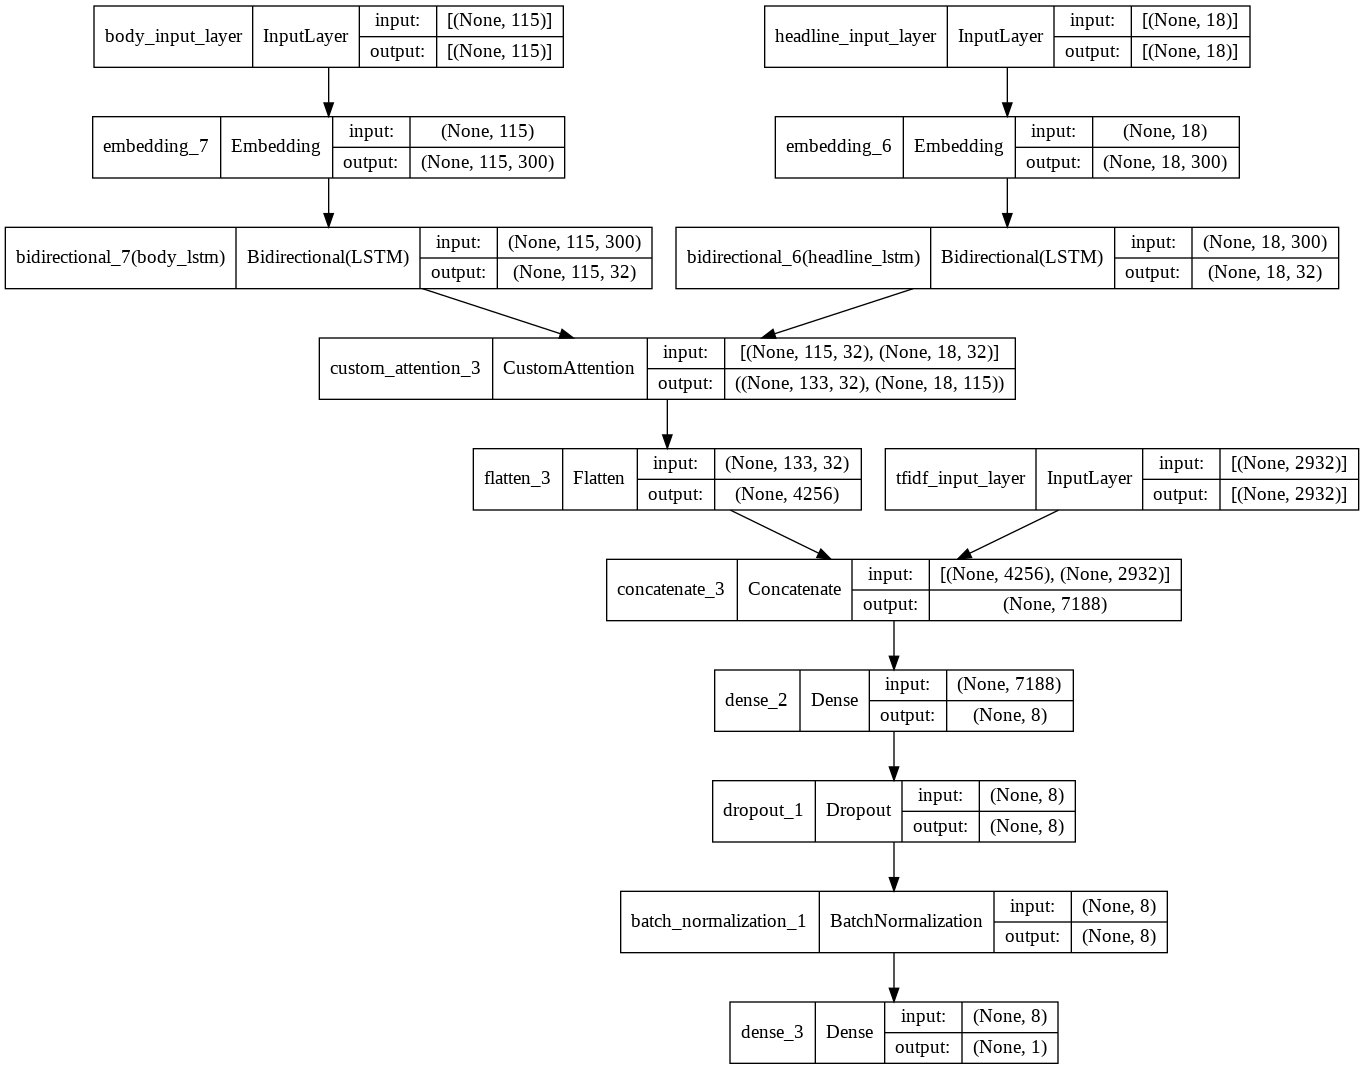

In [26]:
tf.keras.utils.plot_model(model_with_dot_attn, to_file="model_with_dot_attn.png", show_shapes=True)

In [27]:
num_epoch = 200
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model training
model_log_dot_attn = model_with_dot_attn.fit([train_headline_sequences_padded, train_body_sequences_padded, X_train_headline_body], train_news_dataset_cleaned_label,
          epochs=num_epoch, verbose=1, batch_size=32, validation_split=0.2, callbacks=[es_callback])

Epoch 1/200
15/15 [==============================] - 19s 478ms/step - loss: 6.7933 - accuracy: 0.5417 - val_loss: 4.3754 - val_accuracy: 0.4750
Epoch 2/200
15/15 [==============================] - 1s 95ms/step - loss: 3.2989 - accuracy: 0.5729 - val_loss: 2.4428 - val_accuracy: 0.6333
Epoch 3/200
15/15 [==============================] - 1s 92ms/step - loss: 2.0519 - accuracy: 0.6062 - val_loss: 1.7180 - val_accuracy: 0.5750
Epoch 4/200
15/15 [==============================] - 1s 93ms/step - loss: 1.5432 - accuracy: 0.5917 - val_loss: 1.3758 - val_accuracy: 0.6917
Epoch 5/200
15/15 [==============================] - 1s 93ms/step - loss: 1.2762 - accuracy: 0.5813 - val_loss: 1.2507 - val_accuracy: 0.7333
Epoch 6/200
15/15 [==============================] - 1s 91ms/step - loss: 1.1791 - accuracy: 0.6167 - val_loss: 1.1662 - val_accuracy: 0.7167
Epoch 7/200
15/15 [==============================] - 1s 92ms/step - loss: 1.0566 - accuracy: 0.6438 - val_loss: 1.0533 - val_accuracy: 0.7000
Epoc

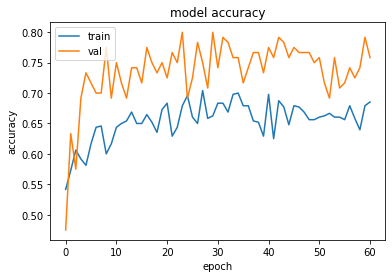

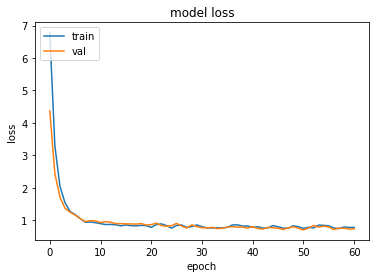

In [28]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(model_log_dot_attn.history['accuracy'])
plt.plot(model_log_dot_attn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_log_dot_attn.history['loss'])
plt.plot(model_log_dot_attn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
test_headline_sequences = tokenizer.texts_to_sequences(news_dataset_test_cleaned["Headline"])
test_body_sequences = tokenizer.texts_to_sequences(news_dataset_test_cleaned["Body"])
# padding test data to feed into network for prediction
test_headline_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    test_headline_sequences, padding='post', maxlen=train_headline_sequences_padded.shape[1]
)
test_body_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    test_body_sequences, padding='post', maxlen=train_body_sequences_padded.shape[1]
)
# getting target label
test_news_dataset_cleaned_label = y_test

In [30]:
# Evaluating the model on held-out test data
model_with_dot_attn.evaluate([test_headline_sequences_padded, test_body_sequences_padded, X_test_headline_body], test_news_dataset_cleaned_label)

5/5 [==============================] - 0s 43ms/step - loss: 0.6927 - accuracy: 0.8742


[0.6927289366722107, 0.8741722106933594]

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        75
           1       0.93      0.82      0.87        76

    accuracy                           0.87       151
   macro avg       0.88      0.87      0.87       151
weighted avg       0.88      0.87      0.87       151

Accuracy: 0.87, F1 Score: 0.87


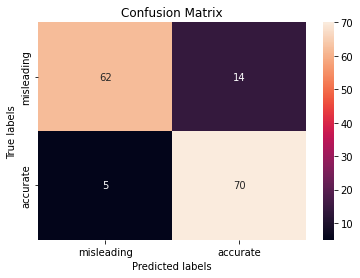

In [31]:
pred = model_with_dot_attn.predict([test_headline_sequences_padded, test_body_sequences_padded, X_test_headline_body])
pred = np.array([0 if x < 0.5 else 1 for x in pred])
true = np.array(test_news_dataset_cleaned_label)
from sklearn.metrics import classification_report
print(classification_report(true, pred))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true, pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true, pred), 2)}, F1 Score: {round(f1_score(true, pred), 2)}")

# Saving the Bi-LSTM + Dot Product Attention + FFNN model

In [ ]:
# Saving the model, tokenizer for future use
model_with_dot_attn.save("/content/drive/MyDrive/Datasets/Saved Models/nna_best_model")
with open('/content/drive/MyDrive/Datasets/Saved Models/nna_best_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_best_model/assets


# Modelling (Bi-LSTM + Additive Attention + FFNN)

In [56]:
headline_length = len(train_headline_sequences_padded[0])
body_length = len(train_body_sequences_padded[0])
embedding_dim = 300
input_headline = tf.keras.layers.Input(shape=(headline_length,), name="headline_input_layer")
embedding_headline = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero=True)(input_headline)

input_body = tf.keras.layers.Input(shape=(body_length,), name="body_input_layer")
embedding_body = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero=True)(input_body)

headline_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="headline_lstm",
                                                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)))(embedding_headline)     
body_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="body_lstm",
                                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)))(embedding_body) 

tf_idf_input = tf.keras.layers.Input(shape=(X_train_headline_body.shape[1],), name="tfidf_input_layer")                                                                  

headline_body_attention_seq = tf.keras.layers.AdditiveAttention(name="additive_attention_layer")([body_lstm, headline_lstm])

body_encoding = tf.keras.layers.GlobalAveragePooling1D()(body_lstm)
headline_body_attention = tf.keras.layers.GlobalAveragePooling1D()(headline_body_attention_seq)  

concat_layer = tf.keras.layers.Concatenate(axis=1)([body_encoding, headline_body_attention])

x = tf.keras.layers.Flatten()(concat_layer)
x = tf.keras.layers.Concatenate()([x, tf_idf_input])
x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_with_add_attn = tf.keras.Model([input_headline, input_body, tf_idf_input], [x])

model_with_add_attn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

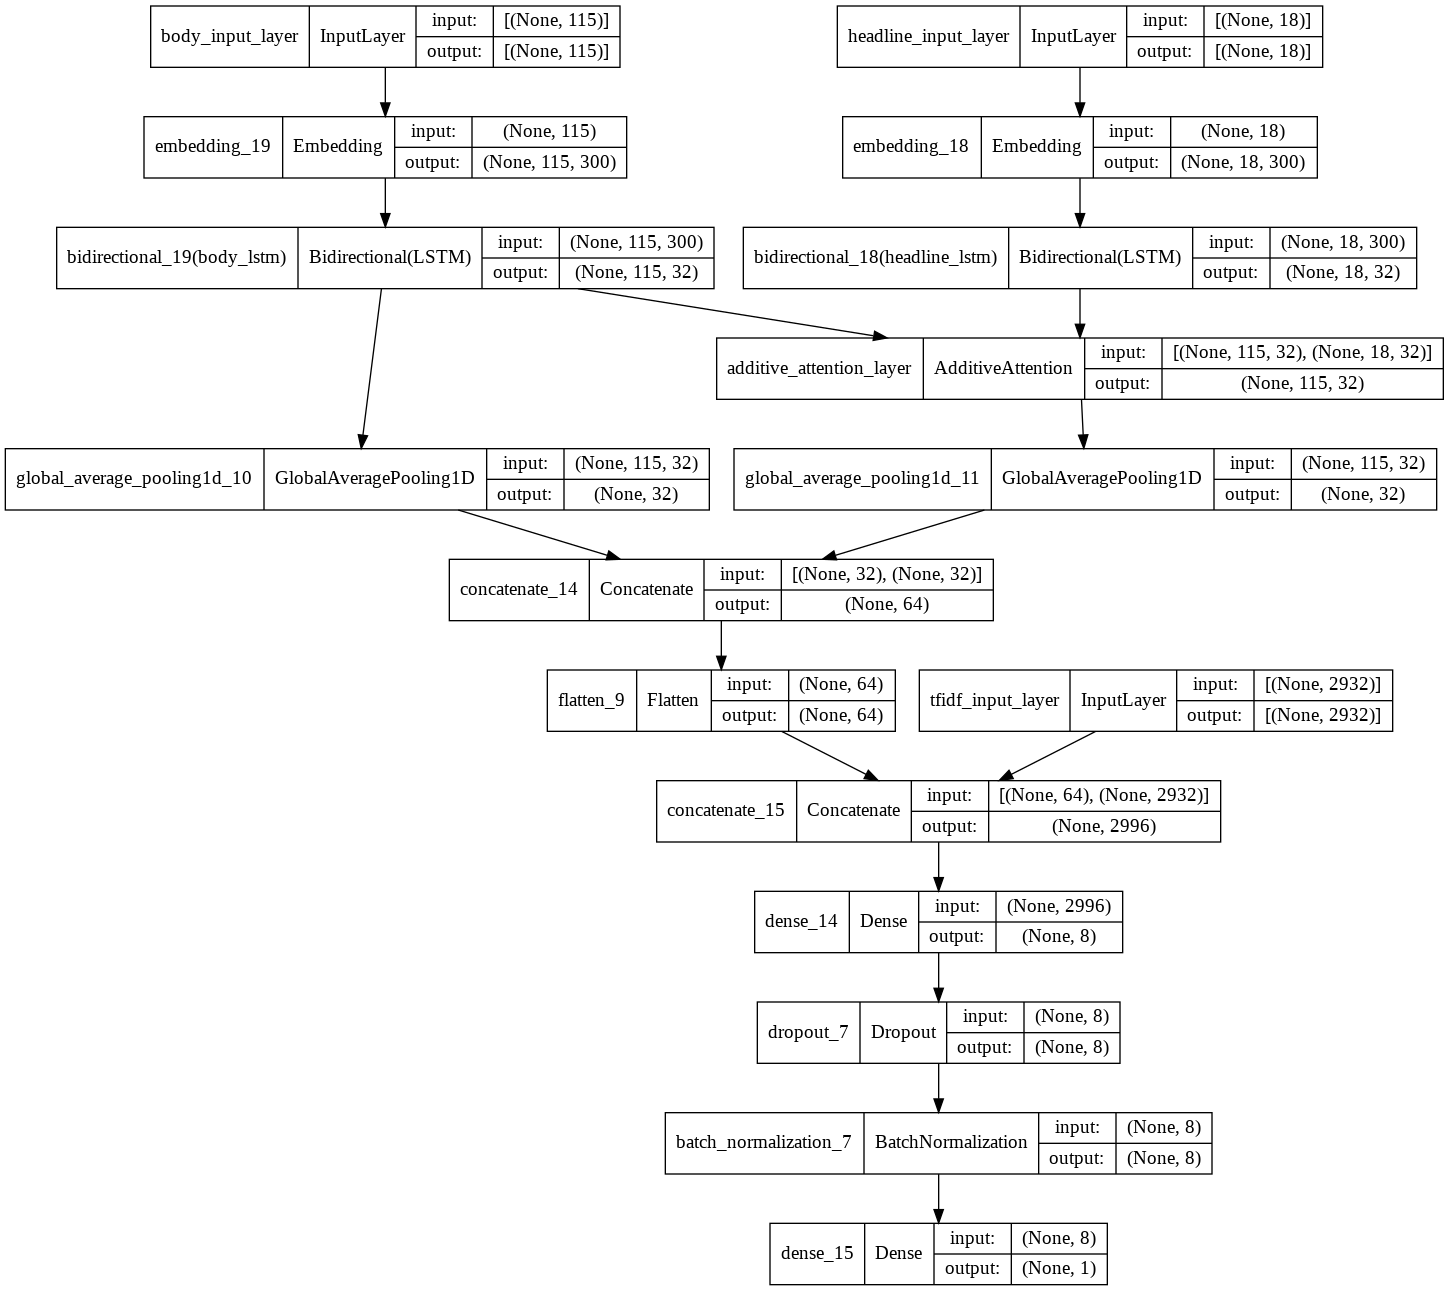

In [57]:
tf.keras.utils.plot_model(model_with_add_attn, to_file="model_with_add_attn.png", show_shapes=True)

In [58]:
num_epoch = 200
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model training
model_log_add_attn = model_with_add_attn.fit([train_headline_sequences_padded, train_body_sequences_padded, X_train_headline_body], train_news_dataset_cleaned_label,
          epochs=num_epoch, verbose=1, batch_size=32, validation_split=0.2, callbacks=[es_callback])

Epoch 1/200
15/15 [==============================] - 20s 539ms/step - loss: 5.4242 - accuracy: 0.5188 - val_loss: 3.9448 - val_accuracy: 0.5250
Epoch 2/200
15/15 [==============================] - 2s 111ms/step - loss: 3.1146 - accuracy: 0.5729 - val_loss: 2.3506 - val_accuracy: 0.5250
Epoch 3/200
15/15 [==============================] - 2s 114ms/step - loss: 1.9225 - accuracy: 0.6125 - val_loss: 1.7057 - val_accuracy: 0.5250
Epoch 4/200
15/15 [==============================] - 2s 112ms/step - loss: 1.5236 - accuracy: 0.6062 - val_loss: 1.4514 - val_accuracy: 0.5250
Epoch 5/200
15/15 [==============================] - 2s 111ms/step - loss: 1.3046 - accuracy: 0.6479 - val_loss: 1.2951 - val_accuracy: 0.5250
Epoch 6/200
15/15 [==============================] - 2s 112ms/step - loss: 1.1575 - accuracy: 0.6812 - val_loss: 1.1917 - val_accuracy: 0.5250
Epoch 7/200
15/15 [==============================] - 2s 110ms/step - loss: 1.0637 - accuracy: 0.7042 - val_loss: 1.1219 - val_accuracy: 0.525

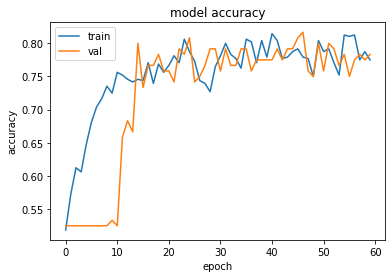

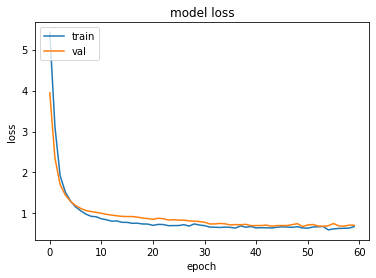

In [59]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(model_log_add_attn.history['accuracy'])
plt.plot(model_log_add_attn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_log_add_attn.history['loss'])
plt.plot(model_log_add_attn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
# Evaluating the model on held-out test data
model_with_add_attn.evaluate([test_headline_sequences_padded, test_body_sequences_padded, X_test_headline_body], test_news_dataset_cleaned_label)

5/5 [==============================] - 0s 35ms/step - loss: 0.6143 - accuracy: 0.8543


[0.6142566204071045, 0.8543046116828918]

              precision    recall  f1-score   support

           0       0.81      0.92      0.86        75
           1       0.91      0.79      0.85        76

    accuracy                           0.85       151
   macro avg       0.86      0.85      0.85       151
weighted avg       0.86      0.85      0.85       151

Accuracy: 0.85, F1 Score: 0.85


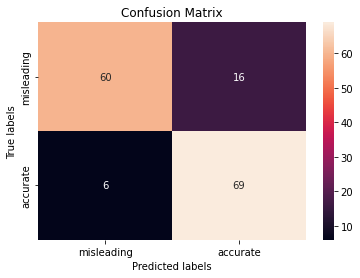

In [61]:
pred = model_with_add_attn.predict([test_headline_sequences_padded, test_body_sequences_padded, X_test_headline_body])
pred = np.array([0 if x < 0.5 else 1 for x in pred])
true = np.array(test_news_dataset_cleaned_label)
from sklearn.metrics import classification_report
print(classification_report(true, pred))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true, pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true, pred), 2)}, F1 Score: {round(f1_score(true, pred), 2)}")

# Saving the Bi-LSTM + Additive Attention + FFNN model

In [62]:
# Saving the model, tokenizer for future use
model_with_add_attn.save("/content/drive/MyDrive/Datasets/Saved Models/nna_additive_attn_best_model")
with open('/content/drive/MyDrive/Datasets/Saved Models/nna_additive_attn_best_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Saved Models/nna_additive_attn_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/Saved Models/nna_additive_attn_best_model/assets


# Modelling (BERT word embeddings + Bi-LSTM + Dot Product Attention + FFNN)

In [ ]:
tokenizer_transformer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert') # please restart after installing sentencepiece library
model_transformer_orig = TFAutoModel.from_pretrained('ai4bharat/indic-bert', from_pt=True)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['sop_classifier.classifier.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel

In [ ]:
# Tokenize train sets
train_headline_tokens = tokenizer_transformer(list(news_dataset_train_cleaned["Headline"]), padding="longest", return_tensors="tf")
train_body_tokens = tokenizer_transformer(list(news_dataset_train_cleaned["Body"]), padding="longest", return_tensors="tf")

train_headline_embeddings = model_transformer_orig(**train_headline_tokens)
train_body_embeddings = model_transformer_orig(**train_body_tokens)

# Tokenize test sets
test_headline_tokens = tokenizer_transformer(list(news_dataset_test_cleaned["Headline"]), padding="max_length", max_length=train_headline_embeddings[0].shape[1], return_tensors="tf")
test_body_tokens = tokenizer_transformer(list(news_dataset_test_cleaned["Body"]), padding="max_length", max_length=train_body_embeddings[0].shape[1], return_tensors="tf")

test_headline_embeddings = model_transformer_orig(**test_headline_tokens)
test_body_embeddings = model_transformer_orig(**test_body_tokens)

In [ ]:
headline_length = train_headline_embeddings[0].shape[1]
body_length = train_body_embeddings[0].shape[1]
embedding_dim = 768

input_headline = tf.keras.layers.Input(shape=(headline_length, embedding_dim,))
input_body = tf.keras.layers.Input(shape=(body_length, embedding_dim,))

headline_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="headline_lstm", 
                                                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(input_headline)     
body_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="body_lstm", 
                                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(input_body) 

headline_body_attention_seq = tf.keras.layers.Attention(dropout=0.7)([body_lstm, headline_lstm])

body_encoding = tf.keras.layers.GlobalAveragePooling1D()(body_lstm)
body_headline_attention = tf.keras.layers.GlobalAveragePooling1D()(headline_body_attention_seq)  

concat_layer = tf.keras.layers.Concatenate(axis=1)([body_encoding, body_headline_attention])

x = tf.keras.layers.Flatten()(concat_layer)
x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_transformer = tf.keras.Model([input_headline, input_body], [x])

model_transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

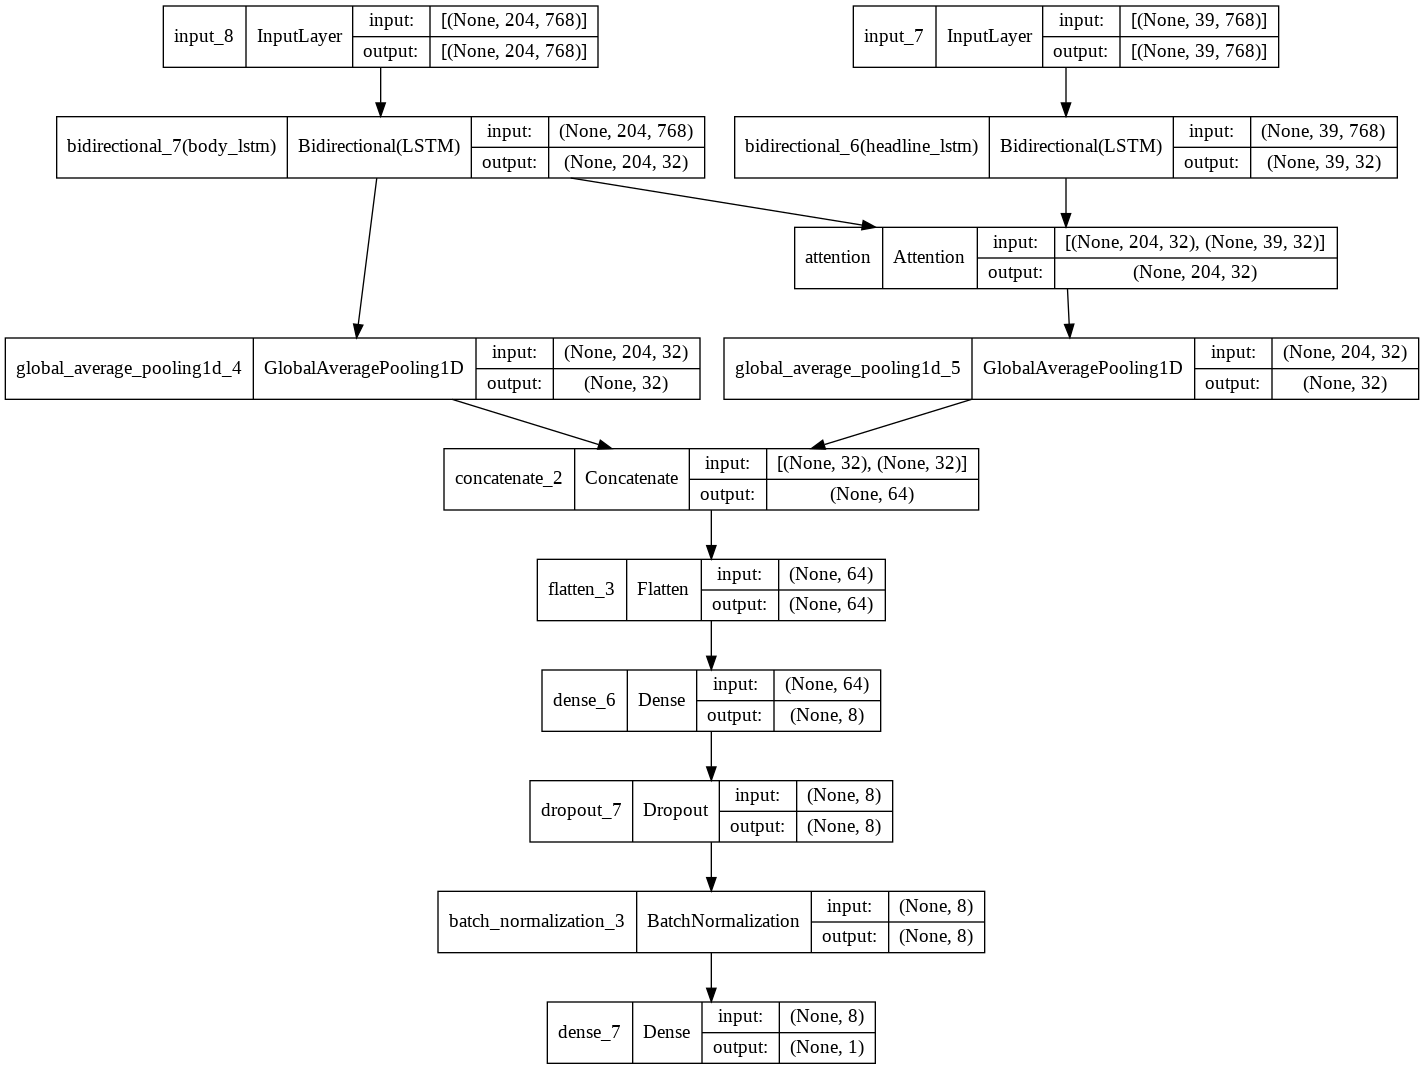

In [ ]:
tf.keras.utils.plot_model(model_transformer, to_file="model_transformer.png", show_shapes=True)

In [ ]:
num_epoch = 100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model training
model_transformer_log = model_transformer.fit([train_headline_embeddings[0], train_body_embeddings[0]], y_train,
          epochs=num_epoch, verbose=1, batch_size=32, validation_split=0.2)#, callbacks=[es_callback])

Epoch 1/100
15/15 [==============================] - 11s 277ms/step - loss: 1.6769 - accuracy: 0.5250 - val_loss: 1.5859 - val_accuracy: 0.4833
Epoch 2/100
15/15 [==============================] - 3s 170ms/step - loss: 1.5795 - accuracy: 0.5542 - val_loss: 1.4721 - val_accuracy: 0.6333
Epoch 3/100
15/15 [==============================] - 2s 168ms/step - loss: 1.4860 - accuracy: 0.5458 - val_loss: 1.4406 - val_accuracy: 0.5750
Epoch 4/100
15/15 [==============================] - 3s 171ms/step - loss: 1.4164 - accuracy: 0.5667 - val_loss: 1.4019 - val_accuracy: 0.5167
Epoch 5/100
15/15 [==============================] - 3s 168ms/step - loss: 1.3746 - accuracy: 0.5500 - val_loss: 1.3586 - val_accuracy: 0.5167
Epoch 6/100
15/15 [==============================] - 2s 168ms/step - loss: 1.3239 - accuracy: 0.5688 - val_loss: 1.3144 - val_accuracy: 0.5167
Epoch 7/100
15/15 [==============================] - 3s 170ms/step - loss: 1.2855 - accuracy: 0.5458 - val_loss: 1.2722 - val_accuracy: 0.525

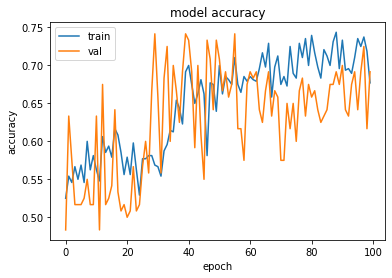

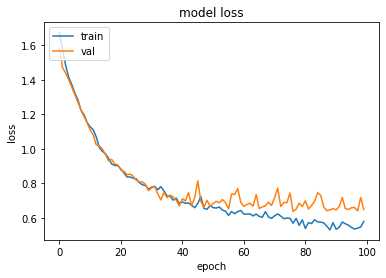

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(model_transformer_log.history['accuracy'])
plt.plot(model_transformer_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_transformer_log.history['loss'])
plt.plot(model_transformer_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluating the model on held-out test data
model_transformer.evaluate([test_headline_embeddings[0], test_body_embeddings[0]], y_test)

5/5 [==============================] - 0s 53ms/step - loss: 0.6299 - accuracy: 0.7020


[0.6298633813858032, 0.7019867300987244]

              precision    recall  f1-score   support

           0       0.73      0.63      0.68        75
           1       0.68      0.78      0.72        76

    accuracy                           0.70       151
   macro avg       0.71      0.70      0.70       151
weighted avg       0.71      0.70      0.70       151

Accuracy: 0.7, F1 Score: 0.72


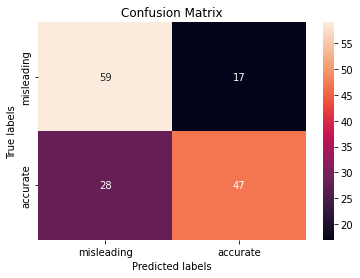

In [ ]:
pred = model_transformer.predict([test_headline_embeddings[0], test_body_embeddings[0]])
pred = np.array([0 if x < 0.5 else 1 for x in pred])
true = np.array(y_test)
from sklearn.metrics import classification_report
print(classification_report(true, pred))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true, pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true, pred), 2)}, F1 Score: {round(f1_score(true, pred), 2)}")

# Saving the BERT word embeddings + Bi-LSTM + Dot Product Attention + FFNN model

In [ ]:
# Saving the model, tokenizer for future use
model_transformer.save("/content/drive/MyDrive/Datasets/Saved Models/nna_transformer_best_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_transformer_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_transformer_best_model/assets


# Model Comparison

This is just a rough comparison of scores each model has after limited hyperparameter tuning. I am sure slight improvements can be made with a bit more aggressive tuning.

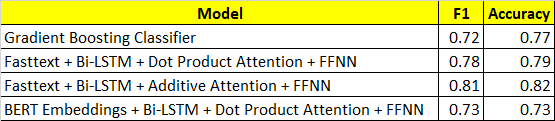

# Experiments

Making predictions on an actual online news articles. 

The model outputs probability of a headline being misleading (due to misuse of superlatives) given each of the paragraphs constituting its body. A probability of less than 0.5 means the superlatives used in the headlines is not misleading and the corresponding paragraph justifies the superlative, as a result the headline-paragraph pair is marked green. For anything higher than that, it gets marked red.

In [63]:
# Load the saved model with best overall accuracy and F1 Score
model_nn = keras.models.load_model('/content/drive/MyDrive/Datasets/Saved Models/nna_additive_attn_best_model')
with open('/content/drive/MyDrive/Datasets/Saved Models/nna_additive_attn_best_model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
vectorizer = load('/content/drive/MyDrive/Datasets/Saved Models/gb_best_model/tf_tdf_vectorizer.joblib')     

In [73]:
def text_cleanup(body_text):
  """Performs all the text pre-processing steps

        Args
        ----------
        body_text : string
            text to be pre-processed

        Returns
        ----------
        pre-processed text
  """
  body_text = remove_english_words(body_text)
  body_text = remove_line_feeds(body_text)
  #body_text = replace_numbers(body_text)
  #body_text = replace_percent(body_text)
  body_text = remove_english_words(body_text)
  body_text = remove_punctuations(body_text)
  body_text = remove_string_numbers(body_text)
  body_text = remove_numbers(body_text)
  body_text = remove_unwanted_chars(body_text)
  body_text = remove_stopwords(body_text)
  body_text = remove_extra_spaces(body_text)
  body_text = remove_leading_trailing_spaces(body_text)
  return body_text

def predict_and_render(url, model, tokenizer, vectorizer):
  """Reads content from an url, identifies headlines and paragraphs, classifies each headline-para pair as misleading or accurate and then color codes them,
     This code currently only supports predictions using fasText embeddings or tf-idf vectorizer as features

        Args
        ----------
        url : string
            url of a news article
        model : saved model (h5, joblib, pickle etc.)
            saved model file
        tokenizer : saved tokenizer (joblib, pickle etc.)
            tokenizer for feature transformation
        vectorizer : saved vectorizer (joblib, pickle etc.)
            vectorizer for feature transformation

        Returns
        ----------
        None
  """
  misleading = "red"  
  try:
      content = BeautifulSoup(requests.get(url).content, "html.parser")
  except:
      content = None
  if content:
      heading = content.find("h1")
      bodies = content.findAll(['p', 'h2', 'h3', 'h4', 'h5', 'h6'])
      for body in bodies:
        # Identify headline
        if len(body.text.strip().split()) >= 20:
          # Pre-processing
          cleaned_body = text_cleanup(body.text)
          cleaned_headline = text_cleanup(heading.text)
          # Feature transformation and predictions
          X_headline = vectorizer.transform([cleaned_headline])
          X_body = vectorizer.transform([cleaned_body])
          X_headline_body = np.concatenate((X_headline.toarray(), X_body.toarray()), axis=1)

          pred_headline_sequences = tokenizer.texts_to_sequences([cleaned_headline])
          pred_headline_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
                      pred_headline_sequences, padding='post', maxlen=model.get_layer("headline_input_layer").output.shape[1]
                      )
          pred_body_sequences = tokenizer.texts_to_sequences([cleaned_body])
          pred_body_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
              pred_body_sequences, padding='post', maxlen=model.get_layer("body_input_layer").output.shape[1]
              )
          
          pred = model.predict([pred_headline_sequences_padded, pred_body_sequences_padded, X_headline_body])
          # Color coding the paragraphs based on preductions
          if 0 <= pred[0][0] < 0.5:
            body.attrs['style'] = "background-color: #6BA515"  
            misleading = "green"
          else:
            body.attrs['style'] = "background-color: #FF0000"
            if misleading != "green":
              misleading = "red"
  #  Color coding the headline based on whether at least one or no justified paragraph was found              
  if misleading == "green":
    heading.attrs['style'] = "background-color: #6BA515"    
  else:
    heading.attrs['style'] = "background-color: #FF0000"        
  from IPython.core.display import HTML
  # Display the color coded article
  display(HTML(str(content))) 

In [74]:
# Predicting on some real news articles
predict_and_render("https://nedricknews.com/business/petrol-diesel-rate-in-different-states-on-friday-5th-november-w57ws", 
                   model_nn, tokenizer, vectorizer)

In [75]:
predict_and_render("https://www.msn.com/hi-in/money/topstories/%E0%A4%B0-%E0%A4%B9%E0%A4%A4-%E0%A4%AD%E0%A4%B0-42%E0%A4%B5-%E0%A4%A6-%E0%A4%A8-%E0%A4%AA%E0%A5%87%E0%A4%9F%E0%A5%8D%E0%A4%B0-%E0%A4%B2-%E0%A4%A1-%E0%A4%9C%E0%A4%B2-%E0%A4%95%E0%A5%87-%E0%A4%A8%E0%A4%8F-%E0%A4%B0%E0%A5%87%E0%A4%9F-%E0%A4%9C-%E0%A4%B0-%E0%A4%87%E0%A4%B8-%E0%A4%B6%E0%A4%B9%E0%A4%B0-%E0%A4%AE%E0%A5%87%E0%A4%82-%E0%A4%B8%E0%A4%AC%E0%A4%B8%E0%A5%87-%E0%A4%AE%E0%A4%B9%E0%A4%82%E0%A4%97/ar-AARRovA?li=AAuuIpA", 
                   model_nn, tokenizer, vectorizer)

शहर,पेट्रोल (रुपये/लीटर),डीज़ल (रुपये/लीटर)
श्रीगंगानगर,112.11,95.26
पोर्ट ब्लेयर,82.96,77.13
जयपुर,107.06,90.70
दिल्ली,95.41,86.67
मुंबई,109.98,94.14
चेन्नई,101.4,91.43
कोलकाता,104.67,89.79
भोपाल,107.23,90.87
रांची,98.52,91.56
बेंगलुरु,100.58,85.01


In [76]:
predict_and_render("https://www.newsnationtv.com/entertainment/bollywood/manuhi-chhillar-reveal-why-november-i-her-luckiet-month-226865.html", 
                   model_nn, tokenizer, vectorizer)

In [77]:
predict_and_render("https://hindi.news18.com/news/ajab-gajab/viral-agarwood-most-rare-and-most-expensive-wood-costly-than-diamond-and-gold-ashas-3768261.html",
                   model_nn, tokenizer, vectorizer)

In [79]:
predict_and_render("https://bollywoodoffice.com/religion-know-which-of-the-4-zodiac-signs-are-the-most-fortunate/", model_nn, tokenizer, vectorizer)

In [81]:
predict_and_render("https://ndtv.in/india-news/sunday-was-the-coldest-day-of-the-season-in-delhi-coldwave-will-still-haunt-2660209#pfrom=home-khabar_delhi", 
                   model_nn, tokenizer, vectorizer)

In [83]:
predict_and_render("https://www.aajtak.in/coronavirus/story/corona-increasing-in-delhi-highest-number-of-cases-came-in-four-months-omicron-variant-in-big-cities-including-mumbai-ntc-1375402-2021-12-17", 
                   model_nn, tokenizer, vectorizer)

In [84]:
predict_and_render("https://www.ekbiharisabparbhari.com/these-are-the-worlds-most-precious-ganpati-whose-value-will-fly-listening-to-your-senses/", 
                   model_nn, tokenizer, vectorizer)

In [85]:
predict_and_render("https://www.ekbiharisabparbhari.com/asias-largest-ethanol-plant-will-be-built-in-bihar-with-250-crores-know-what-will-be-special/", 
                   model_nn, tokenizer, vectorizer)